In [106]:
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import h5py  
import numpy as np
import os 
from scipy.misc import imresize, imsave
import cv2
import random
import soundfile as sf

In [2]:
class AudioDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, train, frames_len=40, transform=None, h5_file='/media/jeff/Backup/CS598PS/data_2682.h5', transform_label=None):
        """
        Args:
            train (bool): Whether or not to use training data
            frames (int): Number of video frames per video sample
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train = train
        self.transform = transform
        self.frames_len = frames_len
        
        dataset = h5py.File(h5_file,'r')
        if self.train:
            self.videos_train = np.array(dataset['videos_train'])
            self.sounds_train = np.array(dataset['sounds_train'])
        else:
            self.videos_test = np.array(dataset['videos_test'])
            self.sounds_test = np.array(dataset['sounds_test'])
        dataset.close()
        
    def __len__(self):
        if self.train:
            return len(self.videos_train)
        return len(self.videos_test)

    def __getitem__(self, idx):
        if self.train:
            image = self.videos_train[idx]
            audio = self.sounds_train[idx]
        else:
            image = self.videos_test[idx]
            audio = self.sounds_test[idx]

        # Randomly sample 4 seconds from 10 second clip
        if random.random() < 0.5:
            start = random.randint(0,10) # Start frame
        else:
            start = random.randint(50,60)
        new_image = np.zeros((self.frames_len,256,256,1), dtype=np.uint8)
        for i in range(self.frames_len):
            new_image[i] = np.expand_dims(image[start+i],2)
        
        # Randomly align or misalign audio sample
        if random.random() < 0.5: # align
            audio = audio[int(start*220500/100.0):int(start*220500/100.0)+88200]
            label = 0
        else: # misalign
            if start < 30: # Add shift
                shift = random.randint(20, 60-start) # frame shift amount
                start = start+shift
            else: # Subtract shift
                shift = random.randint(20, start) # frame shift amount
                start = start-shift
            audio = audio[int(start*220500/100.0):int(start*220500/100.0)+88200]
            label = 1
            
        transform_image = np.zeros((self.frames_len,1,224,224))
        if self.transform:
            for i in range(self.frames_len):
                transform_image[i] = self.transform(new_image[i]) # Transform image frames
        
        return (transform_image, audio, label)

In [3]:
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Block2(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, kernel_size, stride, downsample=None):
        super(Block2, self).__init__()
        self.out_channels = out_channels
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding=0, dilation=1, groups=1, bias=True)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Block3(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, kernel_size=(1,1,1), stride=1, downsample=None, padding=0):
        super(Block3, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=1, groups=1, bias=True)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=(1,1,1), stride=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

def Linear(in_features, out_features, dropout=0.):
    m = nn.Linear(in_features, out_features)
    m.weight.data.normal_(mean=0, std=math.sqrt((1 - dropout) / in_features))
    m.bias.data.zero_()
    return nn.utils.weight_norm(m)

class alignment(nn.Module):
    def __init__(self):
        super(alignment, self).__init__()
        """Sound Features"""
        self.conv1_1 = nn.Conv1d(2, 64, 65, stride=4, padding=0, dilation=1, groups=1, bias=True)
        self.pool1_1 = nn.MaxPool1d(4, stride=4)

        self.s_net_1 = self._make_layer(Block2, 64, 128, 15, 4, 1)
        self.s_net_2 = self._make_layer(Block2, 128, 128, 15, 4, 1)
        self.s_net_3 = self._make_layer(Block2, 128, 256, 15, 4, 1)
        
        self.pool1_2 = nn.MaxPool1d(3, stride=3)
        self.conv1_2 = nn.Conv1d(256, 128, 3, stride=1, padding=0, dilation=1, groups=1, bias=True)
        
        """Image Features"""
        self.conv3_1 = nn.Conv3d(1, 64, (5,7,7), (2,2,2), padding=(2,3,3), dilation=1, groups=1, bias=True)
        self.pool3_1 = nn.MaxPool3d((1,3,3), (1,2,2), padding=(0,1,1))
        self.im_net_1 = self._make_layer(Block3, 64, 64, (3,3,3), (2,2,2), 2)

        """Fuse Features"""
        self.fractional_maxpool = nn.FractionalMaxPool2d((3,1), output_size=(10, 1))
        self.conv3_2 = nn.Conv3d(192, 512, (1, 1, 1))
        self.conv3_3 = nn.Conv3d(512, 128, (1, 1, 1))
        self.joint_net_1 = self._make_layer(Block3, 128, 128, (3,3,3), (2,2,2), 2)
        self.joint_net_2 = self._make_layer(Block3, 128, 256, (3,3,3), (1,2,2), 2)
        self.joint_net_3 = self._make_layer(Block3, 256, 512, (3,3,3), (1,2,2), 2)

        #TODO: Global avg pooling, fc and sigmoid
        self.fc = Linear(512,2)

    def _make_layer(self, block, in_channels, out_channels, kernel_size, stride, blocks):
        downsample = None
        if stride != 1 or in_channels != out_channels * block.expansion:
            if isinstance(kernel_size, int):
                downsample = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels * block.expansion, kernel_size, stride),
                    nn.BatchNorm1d(out_channels * block.expansion),
                )
                layers = []
                layers.append(block(in_channels, out_channels, kernel_size, stride, downsample))
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(in_channels, out_channels * block.expansion, kernel_size, stride, padding=1),
                    nn.BatchNorm3d(out_channels * block.expansion),
                )
                layers = []
                layers.append(block(in_channels, out_channels, kernel_size, stride, downsample, padding=1))

        
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, sounds, images):
        batchsize = sounds.shape[0]
        sounds = sounds.view(batchsize, 2, -1)
        _, num, _, xd, yd, = images.shape
        images = images.view(batchsize, 1, num, xd, yd)
        
        out_s = self.conv1_1(sounds)
        out_s = self.pool1_1(out_s)

        out_s = self.s_net_1(out_s)
        out_s = self.s_net_2(out_s)
        out_s = self.s_net_3(out_s)

        out_s = self.pool1_2(out_s)
        out_s = self.conv1_2(out_s)
        
        out_im = self.conv3_1(images)
        out_im = self.pool3_1(out_im)
        out_im = self.im_net_1(out_im)

        #tile audio, concatenate channel wise
        out_s = self.fractional_maxpool(out_s.unsqueeze(3)) # Reduce dimension from 25 to 8
        out_s = out_s.squeeze(3).view(-1, 1, 1).repeat(1, 28, 28).view(-1,128,10,28,28) # Tile
        out_joint = torch.cat((out_s, out_im),1)
        out_joint = self.conv3_2(out_joint)
        out_joint = self.conv3_3(out_joint)
        out_joint = self.joint_net_1(out_joint)
        out_joint = self.joint_net_2(out_joint)
        out_joint = self.joint_net_3(out_joint)
        feature_maps = out_joint
        """Global Average Pooling"""
        out_joint = F.avg_pool3d(out_joint, kernel_size=out_joint.size()[2:]).view(batchsize,-1)
#         out_joint = out_joint.view(batchsize, 512, -1).mean(2)
        out_joint = self.fc(out_joint)
        out_joint = torch.sigmoid(out_joint)
        return out_joint, feature_maps

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

transform = transforms.Compose([
transforms.ToPILImage(),
# transforms.RandomHorizontalFlip(),
transforms.RandomCrop(224),
transforms.ToTensor()])

train_dataset = AudioDataset(train=True,transform=transform,h5_file='/media/jeff/Backup/CS598PS/data_nice_2597.h5')
test_dataset = AudioDataset(train=False,transform=transform,h5_file='/media/jeff/Backup/CS598PS/data_nice_2597.h5')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=4)



In [5]:
model_align = alignment().cuda()
checkpoint = torch.load("nice_350.pth")
model_align.load_state_dict(checkpoint.state_dict())

# Training

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer_align = optim.Adam(model_align.parameters(), lr = 5e-6)
for epoch in range(500):
    accs = []
    losses = []
    model_align.train()
    for batch_idx, (images, sounds, labels) in enumerate(train_loader):
        images_v = Variable(images.type(torch.FloatTensor)).cuda()
        sounds_v = Variable(sounds.type(torch.FloatTensor)).cuda()
        labels_v = Variable(labels).cuda()
        
        optimizer_align.zero_grad()
        aligned_res, _ = model_align(sounds_v, images_v)
        loss = loss_fn(aligned_res, labels_v)
        loss.backward()
        optimizer_align.step()
        losses.append(loss.item())
        accs.append(np.mean((torch.argmax(aligned_res,1) == labels_v).detach().cpu().numpy()))
    print("Epoch :", epoch, np.mean(losses), np.mean(accs))
    if (epoch + 1)%25 == 0:
        accs = []
        losses = []
        model_align.eval()
        for batch_idx, (images, sounds, labels) in enumerate(test_loader):
            with torch.no_grad():
                images_v = Variable(images.type(torch.FloatTensor)).cuda()
                sounds_v = Variable(sounds.type(torch.FloatTensor)).cuda()
                labels_v = Variable(labels).cuda()
                aligned_res, _ = model_align(sounds_v, images_v)
                loss = loss_fn(aligned_res, labels_v)
                losses.append(loss.item())
                accs.append(np.mean((torch.argmax(aligned_res,1) == labels_v).detach().cpu().numpy()))
        print("Validation :", epoch, np.mean(losses), np.mean(accs))
torch.save(model_align, 'nice_500.pth')

('Epoch :', 0, 0.65239099758427321, 0.61608231707317074)
('Epoch :', 1, 0.64772734845556867, 0.61158536585365852)
('Epoch :', 2, 0.65166441333003156, 0.60663109756097555)
('Epoch :', 3, 0.650850814290163, 0.61150914634146336)
('Epoch :', 4, 0.66031158624625785, 0.5865853658536585)
('Epoch :', 5, 0.64492395665587443, 0.62317073170731707)
('Epoch :', 6, 0.64834016270753814, 0.61585365853658536)
('Epoch :', 7, 0.64223679536726419, 0.62240853658536588)
('Epoch :', 8, 0.64998906051240313, 0.620655487804878)
('Epoch :', 9, 0.64810227257449449, 0.61798780487804872)
('Epoch :', 10, 0.63832375479907522, 0.63483231707317067)
('Epoch :', 11, 0.64638880985539138, 0.62644817073170733)
('Epoch :', 12, 0.6442855385745444, 0.62012195121951219)
('Epoch :', 13, 0.6450304854206923, 0.63246951219512193)
('Epoch :', 14, 0.64776679219269173, 0.63178353658536579)
('Epoch :', 15, 0.64429904120724379, 0.62751524390243896)
('Epoch :', 16, 0.64720428498779858, 0.62416158536585364)
('Epoch :', 17, 0.6454136008169

Process Process-444:
Process Process-443:
Process Process-441:
Traceback (most recent call last):
Process Process-442:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py

KeyboardInterrupt: 

# Feature Map Visualization

In [114]:
def generate_html(img_paths,loss,accuracy,val_accuracy,epoch,save_path='',img_size=600):
    '''
    @ img_path: A nested list N_images x 5 (# feature maps per image)
                e.g., [[img1_fm1.jpg,img1_fm2.jpg,...],
                       [img2_fm1.jpg,img2_fm2.jpg,...],
                       ...]
    @ loss: float
    @ accuracy: float
    @ epooch: int
    @ save_path: directory to store the html file
    
    return:
    @ html_filename: path to the generated html file
    '''
    # generate a html for each epoch to visualize everything
    html_filename = '%s/visualization_epoch%d.html' % (save_path,epoch)
    with open(html_filename,'w') as f:
        # write meta
        f.write("<!DOCTYPE html>\n<html lang='en'>\n<head>\n<meta charset='UTF-8'>\n<title>\n</title>\n</head>\n<body>\n")
        headline = "<h1> Epoch #%d Visualization</h1>" % epoch
        f.write(headline)
        # write loss and accuracy
        statline = "<h2> Loss: %.4f, Accuracy: %.4f, Validation Accuracy: %.4f </h2>" % (loss,accuracy,val_accuracy)
        f.write(statline)
        # write visualization for every images
        f.write("<h2>Example Outputs</h2>")
        for ind,example_path in enumerate(img_paths):
            f.write("<h4> Example #%d </h4>\n <p> " % (ind+1))
            for i,img_path in enumerate(example_path):
                relative_path = '/'.join(img_path.split('/')[-2:])
                imageline = "<img id='%d' height='%d' src='%s'> &nbsp &nbsp" % (ind, img_size,relative_path)
                f.write(imageline)
            f.write('</p>\n')
        # finished
        f.write("</body>\n</html>\n")
    return html_filename
             
            
def visualize_in_all(epoch,loss,accuracy,val_accuracy,images,heatmaps,result_directory):
    '''
    This function is supposed to be called every epoch
    @params images: N x 5 x 224 x 224 list, (N is # of example selected to visualize)
    @params heatmaps: N x 5 x 224 x 224 list
    '''
    # check file path
    if not os.path.exists(result_directory):
        os.makedirs(result_directory)
        print('create folder %s' % result_directory)
    main_folder = result_directory+'/epoch%d'%epoch
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
        print('create folder %s' % main_folder)
    
    # generate all bboxed images
    num_example = len(images)
    example_paths = []
    # for every image
    for i in range(num_example):
        curr_folder = '%s/%s_%d' % (main_folder,'image',i)
        if not os.path.exists(curr_folder):
            os.makedirs(curr_folder)
            print('create folder %s' % curr_folder)
        folder_paths = []
        for j in range(5):
            plt.imshow(images_lst[i][j], cmap='gray'), plt.axis('off'), plt.axis('off')
            plt.imshow(outputs_lst[i][j], cmap='jet', alpha=0.5)
            plt.savefig(curr_folder+'/' + 'image_' + str(i) + '_' + str(j) + '.jpg')
            plt.close()
            folder_paths.append(curr_folder+'/' + 'image_' + str(i) + '_' + str(j) + '.jpg')
        example_paths.append(folder_paths)
     
    # generate html
    return generate_html(example_paths,loss,accuracy,val_accuracy,epoch,save_path=main_folder,img_size=224)

def activation(feature_map, weights, label):
    output = np.zeros((224,224))
    for i in range(512):
        output += imresize(feature_map[i], (224,224))*weights[label,i]
    return output

In [89]:
for name, param in model_align.state_dict().items():
    if name =='fc.weight_v':
        weight = param
        
images_lst = []
outputs_lst = []

for i in range(100):
    images, sounds, labels = test_dataset[i]
    images_v = Variable(torch.tensor(images)).type(torch.FloatTensor).cuda().unsqueeze(0)
    sounds_v = Variable(torch.tensor(sounds)).type(torch.FloatTensor).cuda().unsqueeze(0)
    labels_v = Variable(torch.tensor(labels)).cuda().unsqueeze(0)
    aligned_res, feature_maps = model_align(sounds_v, images_v)

    images_lst.append(images[[4,12,20,28,36],0])
    outputs_lst.append([activation(feature_maps[0,:,i].detach().cpu().numpy(), weight.detach().cpu().numpy(),labels) for i in range(5)])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [115]:
# Generate html with all feature maps and their activations
visualize_in_all(10,1.0,7.0,5.0,images_lst, outputs_lst, 'results')

'results/epoch10/visualization_epoch10.html'

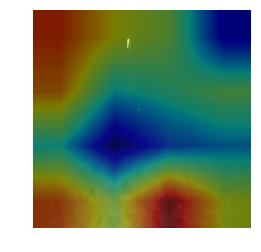

In [101]:
plt.imshow(images_lst[20][3], cmap='gray'), plt.axis('off')
plt.imshow(outputs_lst[20][3], cmap='jet', alpha=0.5)
plt.show()